### Import the necessary libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import re

In [2]:
# NLP libraries
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nilanjana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# ML / DL libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# DL Models 
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore

In [5]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Load Datasets & Create Labels

In [6]:
true_df = pd.read_csv("True.csv")
fake_df = pd.read_csv("Fake.csv")

In [7]:
print("Dataset shape:", true_df.shape)
print("Dataset shape:", fake_df.shape)

Dataset shape: (21417, 4)
Dataset shape: (23481, 4)


In [8]:
true_df['label'] = 1   # Real
fake_df['label'] = 0   # Fake

In [9]:
df = pd.concat([true_df, fake_df], ignore_index=True)
print("Dataset shape:", df.shape)

Dataset shape: (44898, 5)


In [10]:
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [11]:
df.tail()

,title,text,subject,date,label
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0
44897,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",0


### Dropping Date Column

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [13]:
df.drop(columns=['date'], inplace=True)
df.head()

,title,text,subject,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1


### Handling Missing Values

In [14]:
df.isnull().sum()

df['text'] = df['text'].fillna("")
df['title'] = df['title'].fillna("")

### Data Distribution Visualization

In [15]:
df['label'].value_counts()

label
0    23481
1    21417
Name: count, dtype: int64

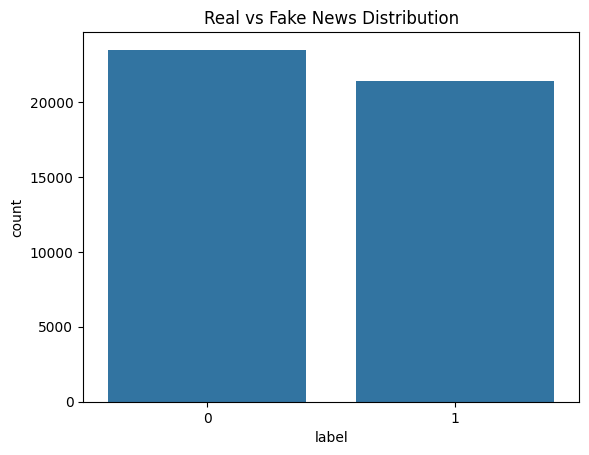

In [16]:
sns.countplot(x='label', data=df)
plt.title("Real vs Fake News Distribution")
plt.show()

### Text Cleaning and Normalization

In [17]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = text.split()
    text = [word for word in text if word not in stop_words]
    return " ".join(text)

df['clean_text'] = df['text'].apply(clean_text)

In [18]:
df[['text', 'clean_text']].head()

,text,clean_text
0,WASHINGTON (Reuters) - The head of a conservat...,washington reuters head conservative republica...
1,WASHINGTON (Reuters) - Transgender people will...,washington reuters transgender people allowed ...
2,WASHINGTON (Reuters) - The special counsel inv...,washington reuters special counsel investigati...
3,WASHINGTON (Reuters) - Trump campaign adviser ...,washington reuters trump campaign adviser geor...
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,seattlewashington reuters president donald tru...


### Tokenization (LSTM & GRU)

In [19]:
MAX_WORDS = 20000
MAX_LEN = 300

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df['clean_text'])

sequences = tokenizer.texts_to_sequences(df['clean_text'])
X = pad_sequences(sequences, maxlen=MAX_LEN)

y = df['label'].values

### Train-Test Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Handling Imbalanced Data

In [21]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight = dict(enumerate(class_weights))

### LSTM Model Training

In [22]:
lstm_model = Sequential([
    Embedding(MAX_WORDS, 128),
    LSTM(128),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [23]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weight,
    callbacks=[early_stop]
)

Epoch 1/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 157s 343ms/step - accuracy: 0.9515 - loss: 0.1445 - val_accuracy: 0.9864 - val_loss: 0.0486
Epoch 2/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 145s 322ms/step - accuracy: 0.9884 - loss: 0.0381 - val_accuracy: 0.9894 - val_loss: 0.0412
Epoch 3/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 141s 314ms/step - accuracy: 0.9947 - loss: 0.0178 - val_accuracy: 0.9864 - val_loss: 0.0525
Epoch 4/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 140s 312ms/step - accuracy: 0.9966 - loss: 0.0126 - val_accuracy: 0.9904 - val_loss: 0.0393
Epoch 5/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 139s 309ms/step - accuracy: 0.9993 - loss: 0.0036 - val_accuracy: 0.9926 - val_loss: 0.0329


In [24]:
lstm_model.save("lstm_model.h5")

### GRU Model Training

In [25]:
gru_model = Sequential([
    Embedding(MAX_WORDS, 128),
    GRU(128),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

gru_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [26]:
history_gru = gru_model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weight,
    callbacks=[early_stop]
)

Epoch 1/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 196s 431ms/step - accuracy: 0.9399 - loss: 0.1612 - val_accuracy: 0.9752 - val_loss: 0.0790
Epoch 2/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 200s 445ms/step - accuracy: 0.9931 - loss: 0.0236 - val_accuracy: 0.9928 - val_loss: 0.0244
Epoch 3/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 233s 519ms/step - accuracy: 0.9884 - loss: 0.0408 - val_accuracy: 0.9922 - val_loss: 0.0267
Epoch 4/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 226s 504ms/step - accuracy: 0.9953 - loss: 0.0200 - val_accuracy: 0.9908 - val_loss: 0.0319


In [27]:
gru_model.save("gru_model.h5")

### Visualization of Model Accuracy vs. Loss

##### Training Curves for LSTM

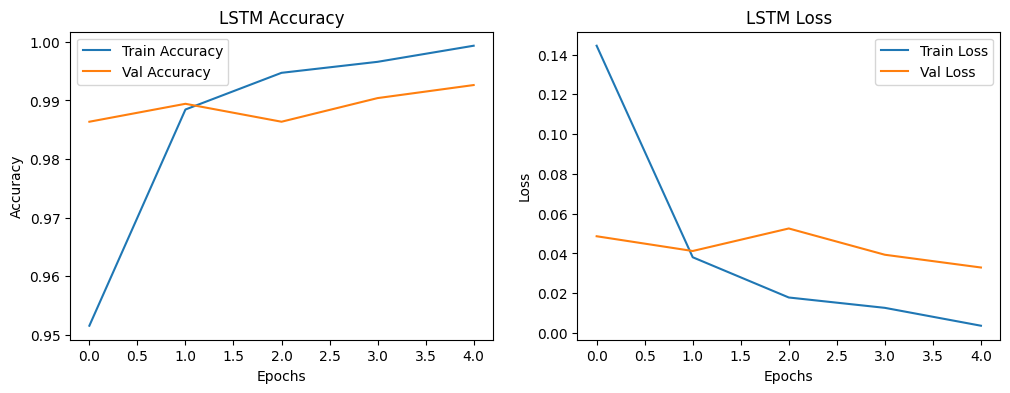

In [28]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title('LSTM Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('LSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

##### Training Curves For GRU

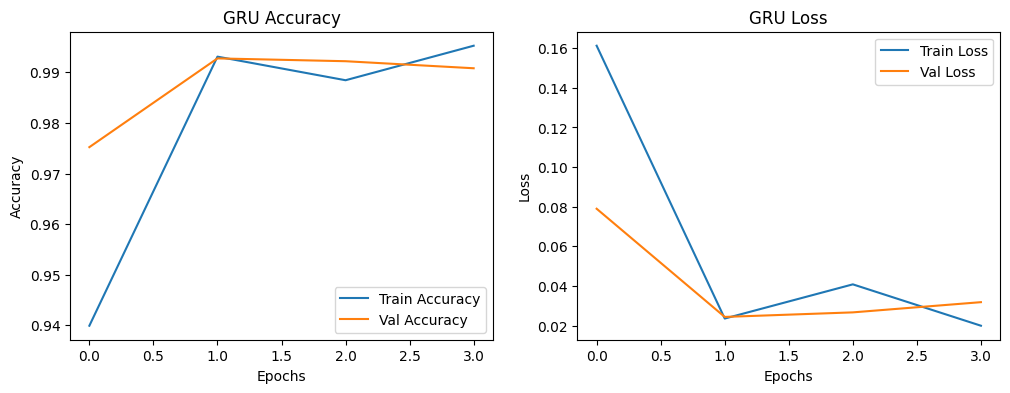

In [29]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Val Accuracy')
plt.title('GRU Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Val Loss')
plt.title('GRU Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

##### Combined Accuracy Comparison

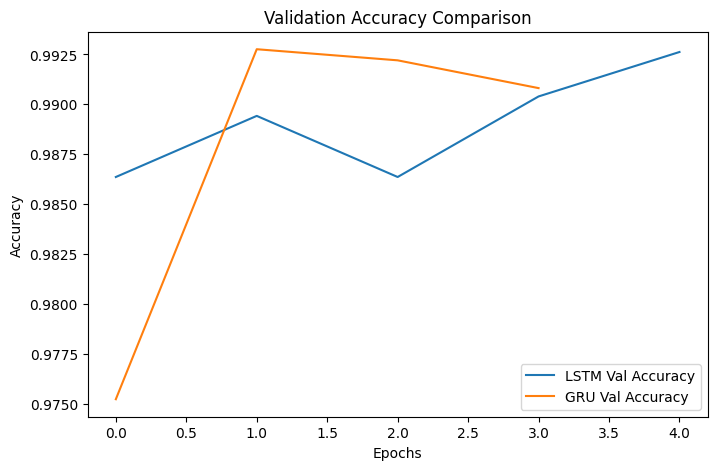

In [30]:
plt.figure(figsize=(8, 5))

plt.plot(history_lstm.history['val_accuracy'], label='LSTM Val Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='GRU Val Accuracy')

plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Model Evaluation

In [31]:
y_pred_lstm = (lstm_model.predict(X_test) > 0.5).astype(int)

print("LSTM")
print(classification_report(y_test, y_pred_lstm))

281/281 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step
LSTM
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4696
           1       0.99      1.00      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [32]:
y_pred_gru = (gru_model.predict(X_test) > 0.5).astype(int)

print("GRU")
print(classification_report(y_test, y_pred_gru))

281/281 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step
GRU
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4696
           1       0.99      1.00      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



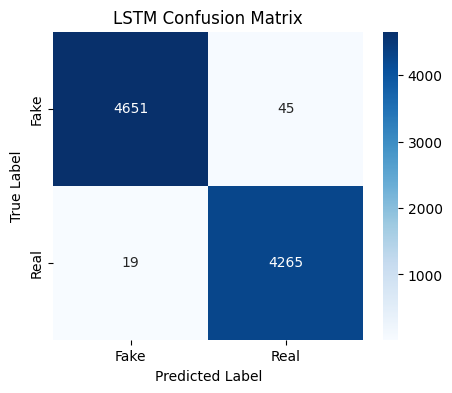

In [33]:
# LSTM Confusion Matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_lstm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Fake', 'Real'],
    yticklabels=['Fake', 'Real']
)

plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

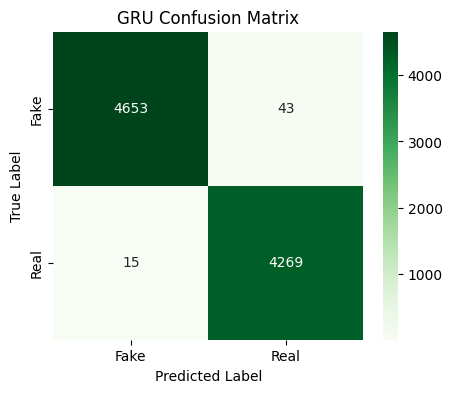

In [34]:
# GRU Confusion Matrix
cm_gru = confusion_matrix(y_test, y_pred_gru)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_gru,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=['Fake', 'Real'],
    yticklabels=['Fake', 'Real']
)

plt.title('GRU Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [35]:
results = {
    "Model": ["LSTM", "GRU"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lstm),
        accuracy_score(y_test, y_pred_gru)
    ],
    "Precision": [
        precision_score(y_test, y_pred_lstm),
        precision_score(y_test, y_pred_gru)
    ],
    "Recall": [
        recall_score(y_test, y_pred_lstm),
        recall_score(y_test, y_pred_gru)
    ],
    "F1-Score": [
        f1_score(y_test, y_pred_lstm),
        f1_score(y_test, y_pred_gru)
    ]
}

In [36]:
comparison_df = pd.DataFrame(results)
comparison_df

,Model,Accuracy,Precision,Recall,F1-Score
0,LSTM,0.992873,0.989559,0.995565,0.992553
1,GRU,0.993541,0.990028,0.996499,0.993253


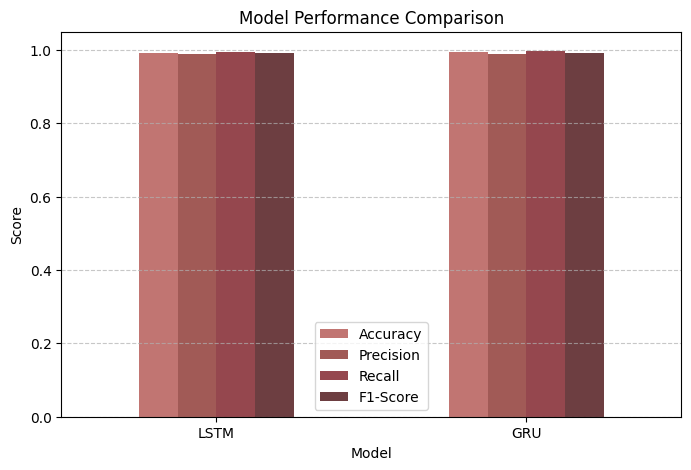

In [37]:
comparison_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1-Score"]].plot(
    kind="bar",
    figsize=(8, 5),
    color=['#c17572', '#a15a56', '#95474e', '#6d3e41']  # custom colors
)

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [38]:
# Get F1 scores
lstm_f1 = comparison_df.loc[comparison_df['Model'] == 'LSTM', 'F1-Score'].values[0]
gru_f1  = comparison_df.loc[comparison_df['Model'] == 'GRU',  'F1-Score'].values[0]

if lstm_f1 > gru_f1:
    print("LSTM performed better than GRU.")
    print(
        "Reason: LSTM performed better due to its ability to capture long-term dependencies "
        "in text sequences using \n\tseparate memory and gating mechanisms."
    )
elif gru_f1 > lstm_f1:
    print("GRU performed better than LSTM.")
    print(
        "Reason: GRU performed better due to its simpler architecture, which allows faster "
        "convergence and better \n\tgeneralization on this dataset."
    )
else:
    print("LSTM and GRU performed equally well.")
    print(
        "Reason: Both models achieved similar performance, indicating comparable learning "
        "capabilities for this dataset."
    )

GRU performed better than LSTM.
Reason: GRU performed better due to its simpler architecture, which allows faster convergence and better 
	generalization on this dataset.


### Saving the Tokenizer

In [39]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)